### Example: Build a model of House prices in California Housing Data

#### Machine Learning Project Checklist:

1. Frame the problem and look at the big picture.

2. Get the data.

3. Explore the data to gain insights.

4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.

5. Explore many different models and short-list the best ones.

6. Fine-tune your models and combine them into a great solution.

7. Present your solution.

8. Launch, monitor, and maintain your system.

More details [here](https://www.safaribooksonline.com/library/view/Hands-On+Machine+Learning+with+Scikit-Learn+and+TensorFlow/9781491962282/app02.html#project_checklist_appendix).

We start by writing a function to fetch the housing data. This can be manually downloaded, however, we are automating so that we get the latest data for our analysis.

In [5]:
import os
import tarfile
from six.moves import urllib

#Hiding all warnings
import warnings; warnings.simplefilter('ignore')


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Next we load the housing data into a Pandas dataframe from the fetched CSV.

In [6]:
import pandas as pd

#method to load the data in Pandas from the earlier fetched data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
  
# Fetch and load housing data
fetch_housing_data()
housing_df=load_housing_data()
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`ocean_proximity` seems like categorical data. We can explore how many categories of data are there, and how many rows for each category.

In [8]:
housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


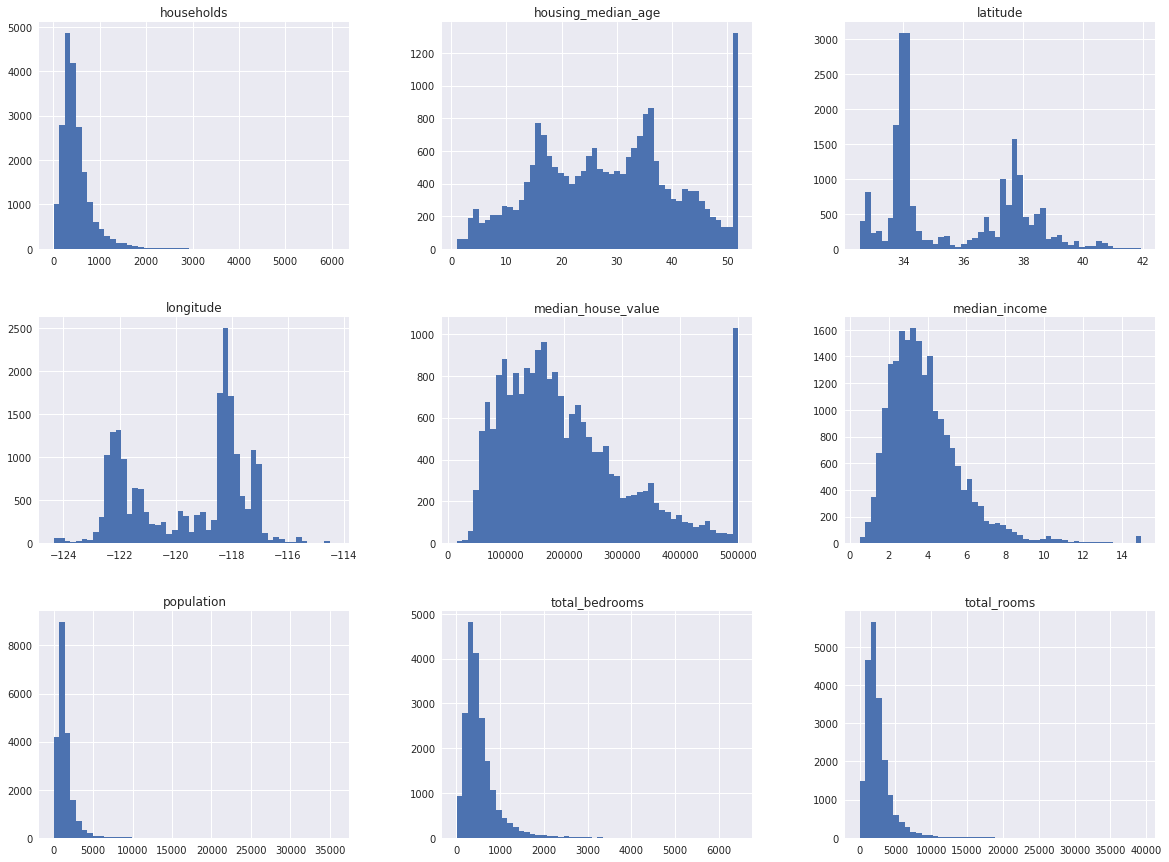

In [10]:
import matplotlib.pyplot as plt
housing_df.hist(bins=50, figsize=(20,15))
plt.show()

Observations from the data:

1. Median income is not in USD. This data is pre-processed.
2. Housing Median Age and Value are capped at the end.
3. Features are not on the same scale.
4. Many features have a long tail.

Create a test set and set it aside:

In [11]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42) # random number seed set to generate the same random permutation every time
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Use the above function to split the data
train_set, test_set = split_train_test(housing_df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Similar function provided by Scikit-learn

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


**Stratified sampling** : The population is divided into homogeneous groups, called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

In [13]:
# Generating income category attribute from median_income attribute
housing_df["income_cat"] = np.ceil(housing_df["median_income"] / 1.5)
housing_df["income_cat"].where(housing_df["income_cat"] < 5, 5.0, inplace=True)
housing_df["income_cat"].value_counts()/len(housing_df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
#Now we do stratified sampling based on the income_cat attribute
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

print("Distribution of train set:")
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))
print("Distribution of test set:")
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))


Distribution of train set:
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
Distribution of test set:
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [15]:
# Now we drop the income category attribute so that data is back to the original form

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Visualizing Data

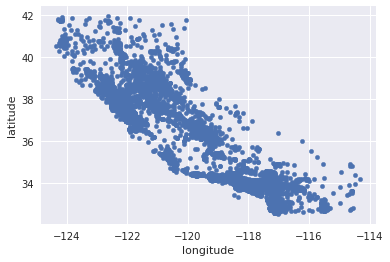

In [16]:
# Make a copy of the data from train set so that we don't modify the actual data by mistake
housing_sample = strat_train_set.copy() # we could have copied only a part of data for visualization as well if the dataset was too large

# Plotting geographical data (lat, long) to see where the districts are located
housing_sample.plot(kind="scatter", x="longitude", y="latitude")

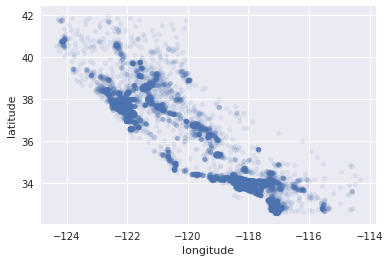

In [17]:
# setting alpha to 0.1 helps visualize the density
housing_sample.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

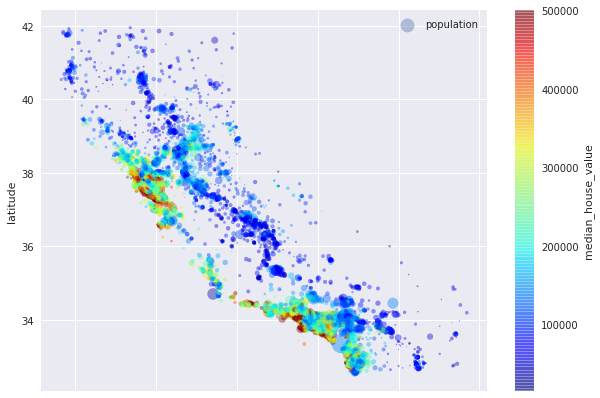

In [18]:
# Analysis of median_house_price by district
housing_sample.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_sample["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

Looking for Correlations

In [19]:
corr_matrix = housing_sample.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff91858b080>,
      dtype=object)

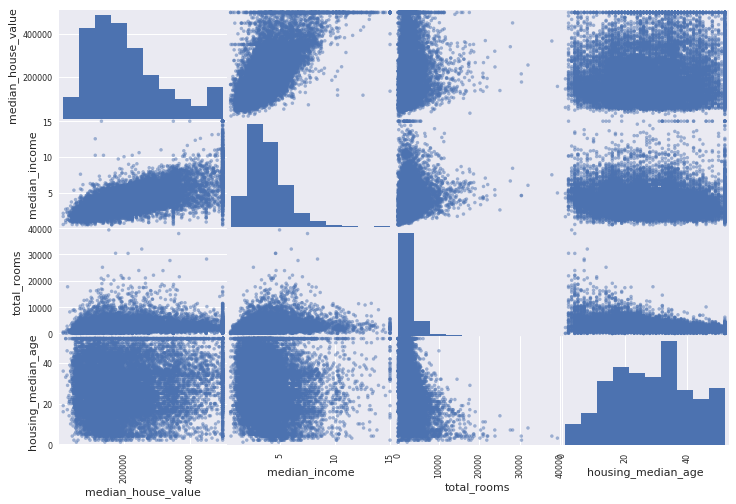

In [20]:
# Visualize correlation between attributes which had high correlation with median_house_value

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_sample[attributes], figsize=(12, 8))

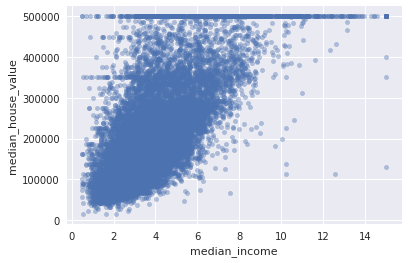

In [21]:
housing_sample.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.4)

### Preparing the data for Machine Learning

In [22]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop function doesn't affect the original array, only makes a copy without the dropped column
housing_labels = strat_train_set["median_house_value"].copy()

#### Handling missing values

If we know there are missing values for one of the attributes in the dataset, we can pursue three options:

1. Remove the data rows where the attribute value is missing.
2. Remove the whole attribute from the dataset.
3. Fill in the missing values with some pre-determined value, such as with the median value of the attribute. If we are doing this, we also save the median value that we used to fill the missing data, as we will later need it to fill the missing values in test set, and also in live data for prediction.

In [23]:
housing_df.dropna(subset=["total_bedrooms"])    # option 1
housing_df.drop("total_bedrooms", axis=1)       # option 2
median = housing_df["total_bedrooms"].median()  # option 3
housing_df["total_bedrooms"].fillna(median, inplace=True)

In `Scikit-learn`, we handle missing values with `Imputer` class.

In [24]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
housing_num = housing_df.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05,  3.0000e+00])

Now we use the trained `Imputer` to transform the training set with missing values.

In [25]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns) # Putting back the resulting Numpy array into a Pandas Dataframe.

Note: API design for `Scikit-learn` project: https://arxiv.org/pdf/1309.0238v1.pdf

#### Handling categorical attributes

In [26]:
housing_cat = housing_df["ocean_proximity"]
housing_cat.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [27]:
# Convert categorical values to numeric equivalent by pandas factorize method
housing_cat_encoded, housing_categories = housing_cat.factorize()

# We can see different housing categories and their index
housing_categories

Index(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype='object')

Next, we do one-hot encoding to avoid the confusion of having numerical representation of the categories having correlation between their values. Numerically, 1 and 2 are closer than 1 and 4, but for the categorical values, there is no such relation.

In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [29]:
# Categorical encoder does the transformation of converting to integer and then 1hot encoding together
# Categorical encoder will be released in Scikit-learn 0.20

# from future_encoders import CategoricalEncoder # or get from notebook
# cat_encoder = CategoricalEncoder()
# housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
# housing_cat_1hot

Post Scikit-learn 0.20 OneHotEncoder will also handle direct conversion from categorical information to integer representationa and then encode it.

In [48]:
from future_encoders import OneHotEncoder

cat_encoder = OneHotEncoder(sparse="False")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.reshape(-1,1))
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

#### Custom transformers

We use custom transformer to create combined attributes that we found to have a good correlation with median house price.

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_df.values)
housing_extra_attribs

array([[-122.23, 37.88, 41.0, ..., 5.0, 6.984126984126984,
        2.5555555555555554],
       [-122.22, 37.86, 21.0, ..., 5.0, 6.238137082601054,
        2.109841827768014],
       [-122.24, 37.85, 52.0, ..., 5.0, 8.288135593220339,
        2.8022598870056497],
       ...,
       [-121.22, 39.43, 17.0, ..., 2.0, 5.20554272517321,
        2.325635103926097],
       [-121.32, 39.43, 18.0, ..., 2.0, 5.329512893982808,
        2.1232091690544412],
       [-121.24, 39.37, 16.0, ..., 2.0, 5.254716981132075,
        2.616981132075472]], dtype=object)

#### Feature Scaling

Two approaches:
1. Min-max scaling (normalization) - `MinMaxScaler` function
2. Standardization - `StandardScaler` function

#### Tranformation pipelines

In [37]:
# Pipeline for numerical attributes

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.62855945,
        -0.04959654, -1.02998783],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.32704136,
        -0.09251223, -0.8888972 ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  1.15562047,
        -0.02584253, -1.29168566],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.09031802,
        -0.0717345 ,  0.02113407],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.04021111,
        -0.09122515,  0.09346655],
       [-0.83369581,  1.75014627, -1.00430931, ..., -0.07044252,
        -0.04368215,  0.11327519]])

In [39]:
# Custom transformer to handle pandas dataframe directly

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now we can write two pipelines, one which uses the dataframe selector to select the numeric attributes and apply transformation on them, the other uses dataframe selector to pick out the categorical attributes and then apply `categoricalEncoder`.

In [45]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse="false")),
    ])

We join these two pipeline using Scikit-learn's `FeatureUninon` class

In [46]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

#we run the full pipeline by passing on the original Housing Dataframe
housing_prepared = full_pipeline.fit_transform(housing_df)
housing_prepared

<20640x18 sparse matrix of type '<class 'numpy.float64'>'
	with 288960 stored elements in Compressed Sparse Row format>

In [53]:
housing_prepared.toarray()


array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])